**Oreum Industries Internal Project, 2024Q3**

---

# 200_AFT_Weibull.ipynb

### Survival Regression Demo in `oreum_survival`


Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

We have departed from equivalents to the pre-packaged max-likelihood models, to use the full power 
of the Bayesian framework to create bespoke models with a variety of hierarchical parameters (aka mixed random effects), 
time-dependent ordinal parameters and more. 

In this __20x_AFT family__  series of notebooks we demonstrate the theory and 
usage of **Accelerated Failure Time (AFT) aka parametric regression** models with different likelihood functions. 

**In this Notebook:**

+ We extend our basic understanding with worked examples of parametric models in the AFT
  architecture family, using our real-world observational censored dataset.
+ Specifically: **A Parametric Regression aka Accelerated Failure Time Model: Weibull**

This notebook directly follows (and is dependent
upon the previous execution of) the `10*_*` series of notebooks, in 
particular `101_Exponential_Regression.ipynb` and the `ExponentialRegression` 
model, using the same simple real-world observational censored dataset.


## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `WeibullRegression`](#2.-Custom-Bayesian-Model-`WeibullRegression`)

---

---


# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here
from scipy import stats

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

from engine import logger, utils
from model import aft, exponential

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('200_AFT_Weibull', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 We extend the Exponential AFT model to use a Weibull likelihood distribution

This follows on directly from NB `101_Exponential_Regression.ipynb` "A Parametric Regression aka Accelerated Failure 
Time Model: Exponential" to create an Accelerated Failure Time (AFT) parametric regression model that uses a 
[Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) for $\hat{\pi}(t)$. A lot of the core model
architecture is the same, for example the `CustomDist` to handle right-censoring.

Modelling $\hat{\pi}(t) \sim \text{Weibull}(t\ |\ \alpha, \gamma)$ can be useful because the Weibull can have a hazard 
function $\lambda$ that's steeper toward the start _or_ the end of the observation period according to shape parameter $\alpha$.

This means it can capture:
+ Early-stage effects like infant mortality, post-operative issues, initial manufacturing shakedown issues etc
+ Late-stage effects like cumulative / mutually reinforcing failures,  senior mortality etc

**NOTE:**

+ The data is the same, the general architecture of the model code is the same, what we're doing is testing a different 
  parametric form which may fit the data better. 
+ Now the Bayesian workflow kicks into gear, because we will be able to easily specify the complex model substructures,
  and demonstrate improvement over the `exponential_regression` model via the log-likelihood performance via LOO-PIT / ELPD.
+ Again refer to `000_Intro.ipynb` $\S \text{Preamble}$ for the myriad reasons this is a better general method to use.

## 1.2 Weibull Model parameters



Intuition:
+ $\hat{\lambda}$ is an unnamed function, proportional to $t^{\alpha - 1}$
+ $\hat{\pi}$ is a [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) function

Showing the main functional relationships in uncensored form (left) and (where relevant $\longrightarrow$ on the right) the censored version

$$
\begin{aligned}
\lambda(t) &= \alpha \gamma \left(\gamma t \right)^{\alpha - 1}
        &\longrightarrow \alpha \gamma \left(\gamma t_{i} \right)^{\alpha - 1,\ {d_{i}}} \\
\Lambda(t) &= (\gamma t)^{\alpha} \\
S(t) &= \exp \left( - (\gamma t)^{\alpha}\right) \\
S^{-1}(u) &= 1/\gamma \left(− \log u \right)^{\frac{1}{\alpha}} \\
\hat{\pi}(t) &\sim \alpha \gamma \left(\gamma t \right)^{\alpha - 1} \cdot  \exp \left( - (\gamma t)^{\alpha}\right)
        &\longrightarrow \alpha \gamma \left(\gamma t_{i} \right)^{\alpha - 1,\ {d_{i}}} \cdot \exp \left( - (\gamma t)^{\alpha}\right) \\
    &\sim \text{Weibull}(t\ |\ \alpha, \gamma) \\
\text{... so:} \\
\log \mathcal{L}\ \hat{\pi}(t) &\sim \log \alpha + \log \gamma + (\alpha - 1) \log (\gamma t) - (\gamma t)^{\alpha}
        &\longrightarrow \sum_{i} d_{i} \left( \log \alpha + \log \gamma +  (\alpha - 1) \log (\gamma t_{i}) \right) - (\gamma t_{i})^{\alpha} \\
\end{aligned}
$$

Where:
+ This 2-parameter form is the same as conventional shape $\alpha$, scale $\gamma$, 
  but easier to notate: shape = $\alpha > 0$, rate = $\gamma = 1/{\sigma} > 0$
+ $d_{i} \in {0, 1}$

When:
  + $\alpha < 1$, hazard decreases over time e.g. infant mortality
  + $\alpha = 1$, hazard is constant $\lambda \sim \gamma$ and the model reduces to the Exponential model
  + $\alpha > 1$, hazard increases over time e.g. senior mortality

## 1.3 Building the linear submodel for regression

Regression considerations:
+ We should choose one parameter for the regression term, or carefully manage the covariance between the two. 
+ Because $\alpha$ affects the shape, we will set $\alpha \sim \exp (\beta^{T}\mathbf{x})$

Prior considerations
+ So our hyperpriors with initial, reasonably uninformative values look like:

$$
\begin{align}
\sigma_{\beta} &\sim \text{Gamma}(\alpha=1, \beta=2)   &\ \ \text{Shared variance for } \beta, \mathbb{E} \sim 0.5 \\
\beta &\sim \text{Normal}(\mu=0, \sigma=\sigma_{\beta})  &\ \ \text{Unpooled } \beta, \mathbb{E} \sim 1 \\
\alpha &= \exp (\mathbf{\beta}^{T}\mathbf{x})         &\ \ \text{Regression prior for } \alpha, \mathbb{E} \sim {1, 2} \\
\gamma &\sim \text{Gamma}(\alpha=1, \beta=200)           &\ \ \text{Pooled } \gamma, \mathbb{E} \sim 0.005 \\
\end{align}
$$

+ Do randomly generated times $t$ look reasonable?

$$
\begin{align}
u &\sim Uniform(0, 1) \\
\hat{t} &\sim \hat{S}^{-1}(u) \\
        &\sim 1/\gamma \ (− \log u )^{\frac{1}{\alpha}} \\
        &\sim 1/0.005 \ (− \log u )^{\frac{1}{1}} \text{, when at } \mathbb{E} \\
        &\approx \begin{cases}
            2 & \textrm{if } u = 0.99 \\
            1000 & \textrm{if } u = 0.01 \\
        \end{cases}
\end{align}
$$

+ Yes, this is a reasonable range of days `duration`, given our dataset
+ However we must beware that the power term $1/\alpha$ makes the $\mathbb{E}(\alpha)$ very sensitive to small values e.g.:
  + If even $\alpha \approx 0.1$, then $\hat{t} \approx [2e^{-18}, 9e^{8}]$ which is way out of range
  + Any values $\alpha << 0.1$ start leading to computation errors



## 1.4 Illustration of functions to aid intuition

Modify $\alpha$, hold $\gamma$ static

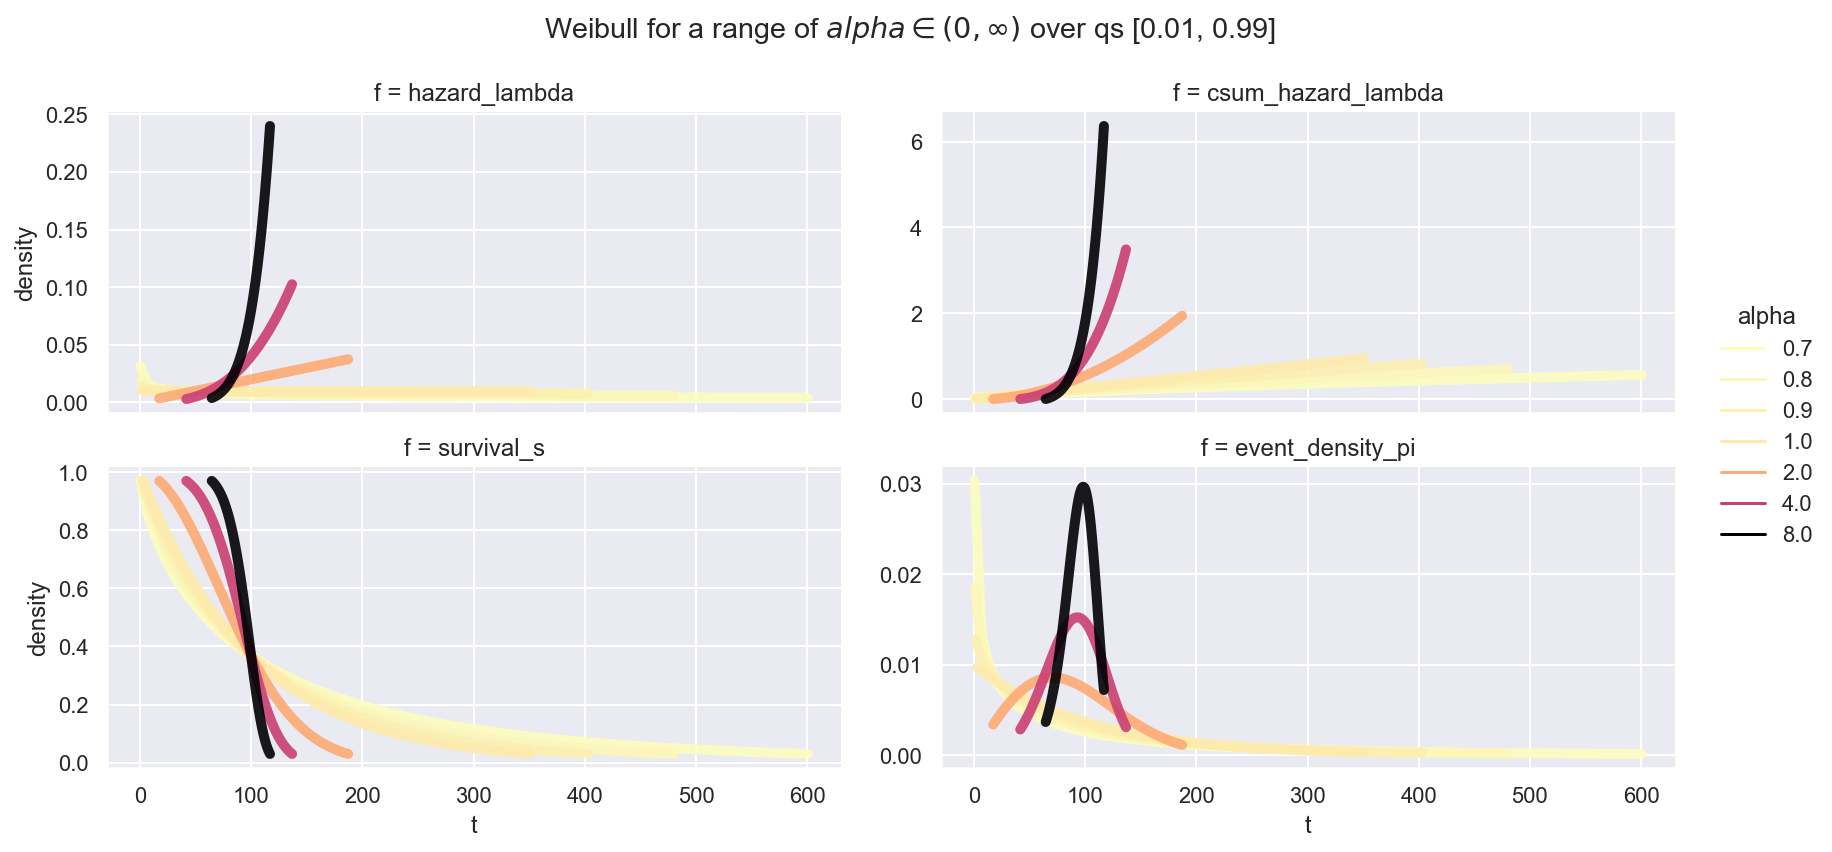

In [7]:
alphas = [0.7, 0.9, 0.8, 1, 2, 4, 8]
gamma = 0.01
dff = pd.concat([utils.get_fs(stats.weibull_min(c=a, scale=1/gamma), {'alpha': a}) for a in alphas])
_ = utils.plot_f(dff, 'Weibull', 'alpha')

Modify $\gamma$, hold $\alpha$ static

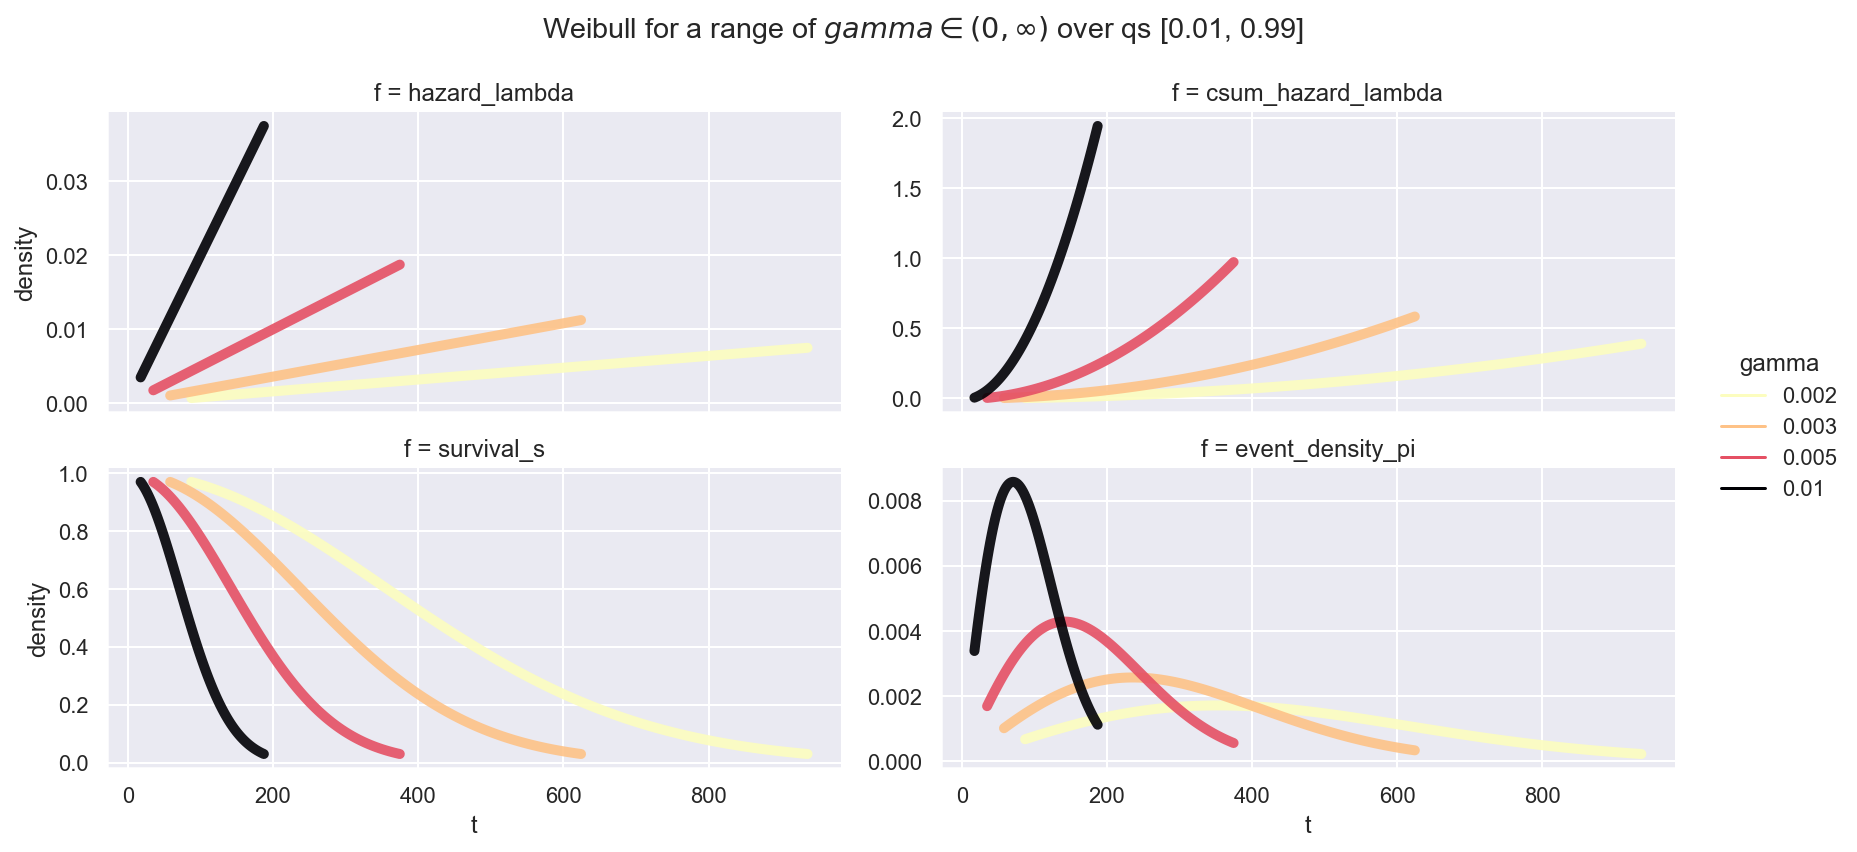

In [8]:
gammas = [0.002, 0.003, 0.005, 0.01]
dff = pd.concat([utils.get_fs(stats.weibull_min(c=2, scale=1/g), {'gamma': g}) for g in gammas])
_ = utils.plot_f(dff, 'Weibull', 'gamma')

---

---

# 2. Custom Bayesian Model `WeibullRegression`

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [9]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 2.1 Build Model Object

`WeibullRegression` model imported from `src.models.aft.py` where it is fully defined

In [10]:
mdl_wr = aft.WeibullRegression(obs=dfx, fts_en=dfx_creator.fts_en, factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_wr.build()
utils.display_rvs(mdl_wr)
mdl_wr.debug()

'RVs for weibull_regression, v1.0.1, dfx'

beta_s ~ Gamma(1, f())

beta ~ Normal(0.2, beta_s)

gamma ~ Gamma(1, f())

alpha ~ Deterministic(f(beta))

shat ~ Deterministic(f(gamma, beta))

point={'beta_s_log__': array(-0.69314718), 'beta': array([0.2, 0.2]), 'gamma_log__': array(-5.29831739)}

No problems found
point={'beta_s_log__': array(-0.69314718), 'beta': array([0.2, 0.2]), 'gamma_log__': array(-5.29831739)}

No problems found


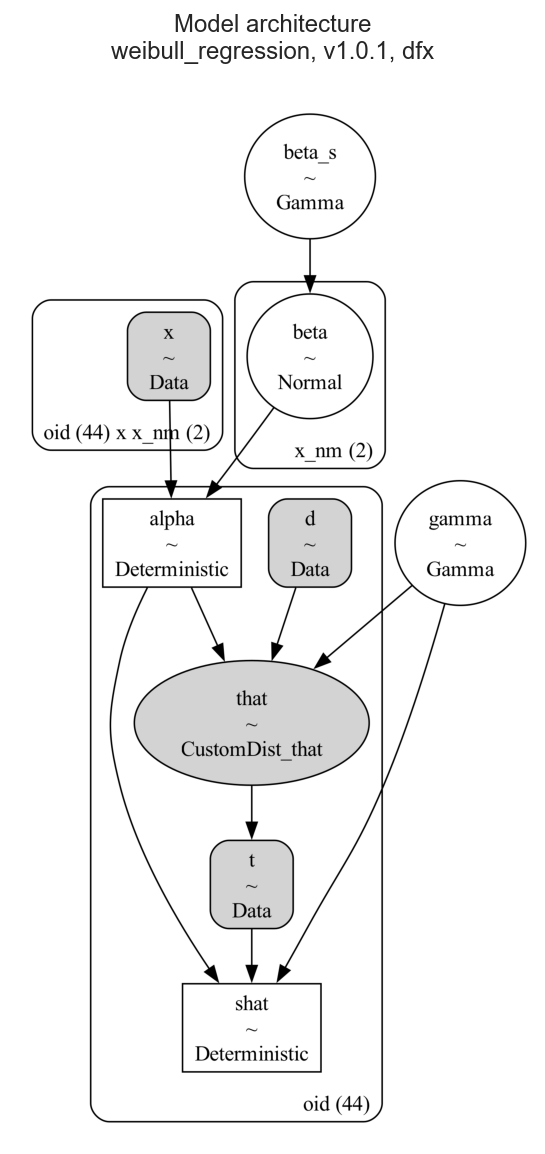

In [11]:
fqn = mdlio.write_graph(mdl_wr)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_wr.mdl_id}', figsize=(12, 8))

## 2.2 Sample Prior Predictive, View Diagnostics

In [12]:
mdl_wr.sample_prior_predictive(var_names=mdl_wr.rvs_prior + mdl_wr.rvs_ppc + mdl_wr.rvs_det, replace=True)

#### Evaluate PPC vs In-Sample Data

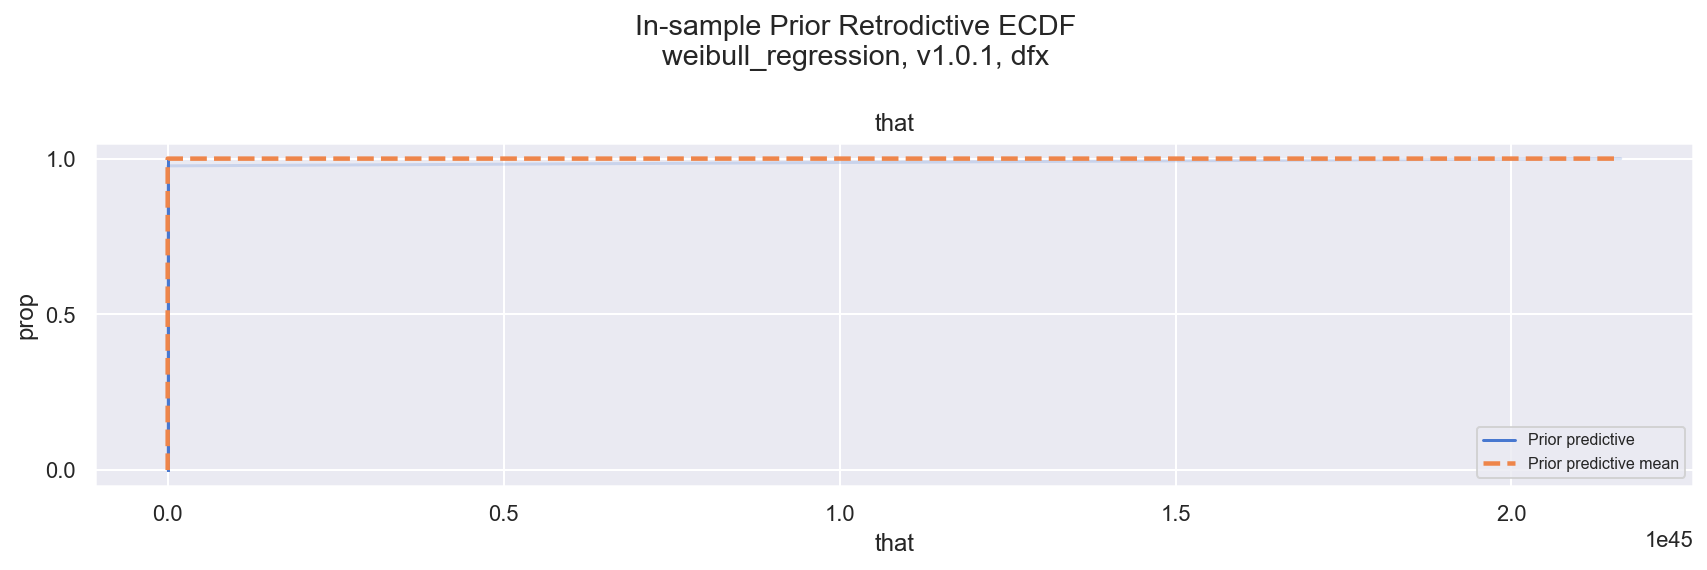

In [13]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_wr, group=GRP, var_names=['that'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is valid (if extremely large)

#### Evaluate priors and hyperpriors

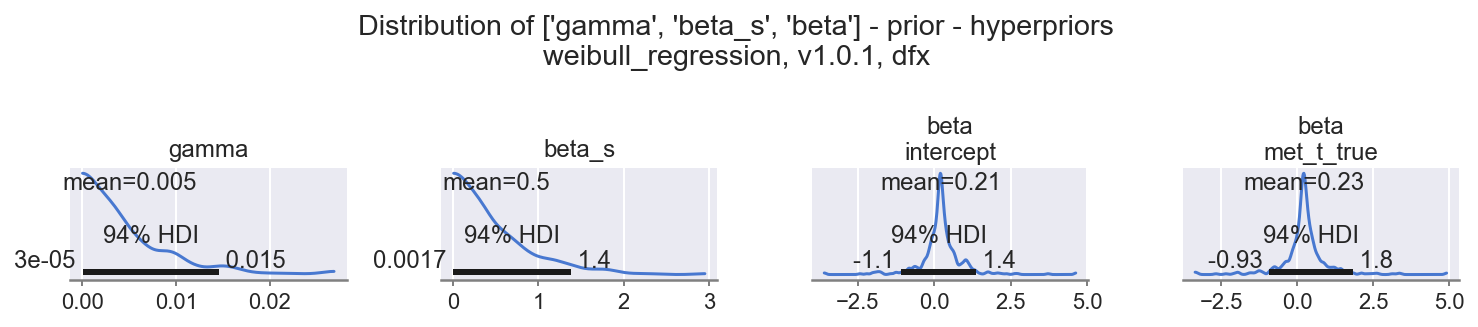

In [14]:
f = mt.facetplot_krushke(mdl=mdl_wr, group=GRP, txtadd='hyperpriors', rvs=mdl_wr.rvs_prior, m=4, rvs_hack=1)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


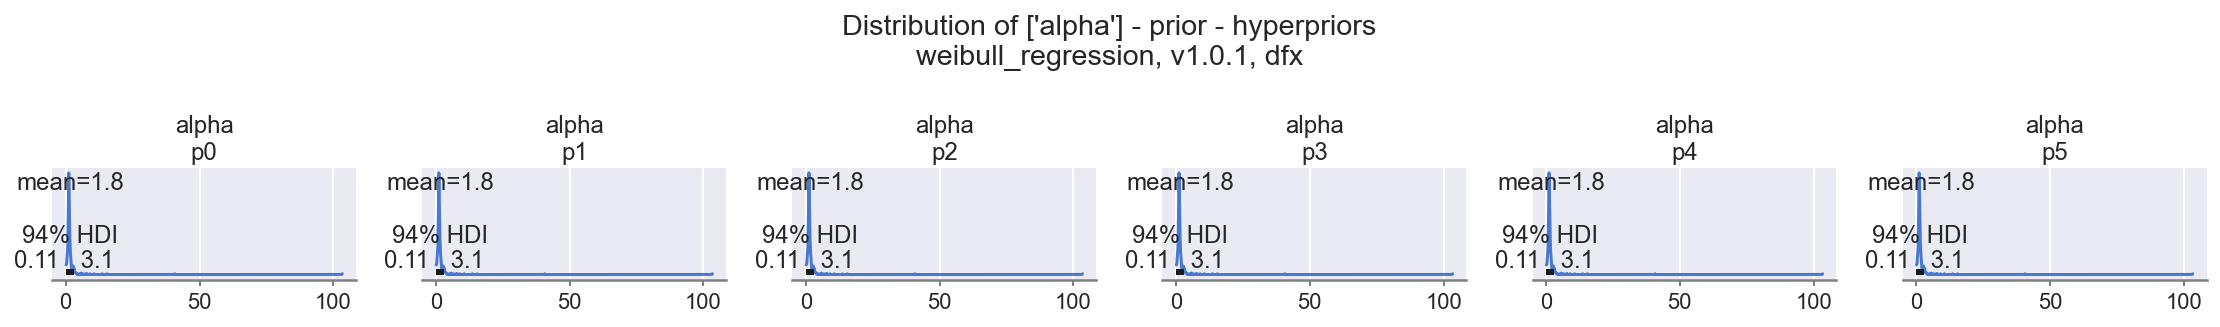

In [15]:
f = mt.facetplot_krushke(mdl=mdl_wr, group=GRP, txtadd='hyperpriors', rvs=mdl_wr.rvs_det, m=6, rvs_hack=0)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdl_wr.sample(progressbar=True)
mdl_wr.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_wr.rvs_ppc)
mdlio.write_idata(mdl=mdl_wr)

Output()

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_weibull_regression_v101_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.006,0.001,0.004,0.008,0.000,0.000,969.0,1009.0,1.00
beta_s,0.479,0.300,0.070,1.017,0.010,0.007,659.0,423.0,1.00
beta[intercept],0.049,0.256,-0.407,0.594,0.009,0.007,824.0,817.0,1.00
beta[met_t_true],-0.172,0.317,-0.864,0.317,0.013,0.009,611.0,934.0,1.01


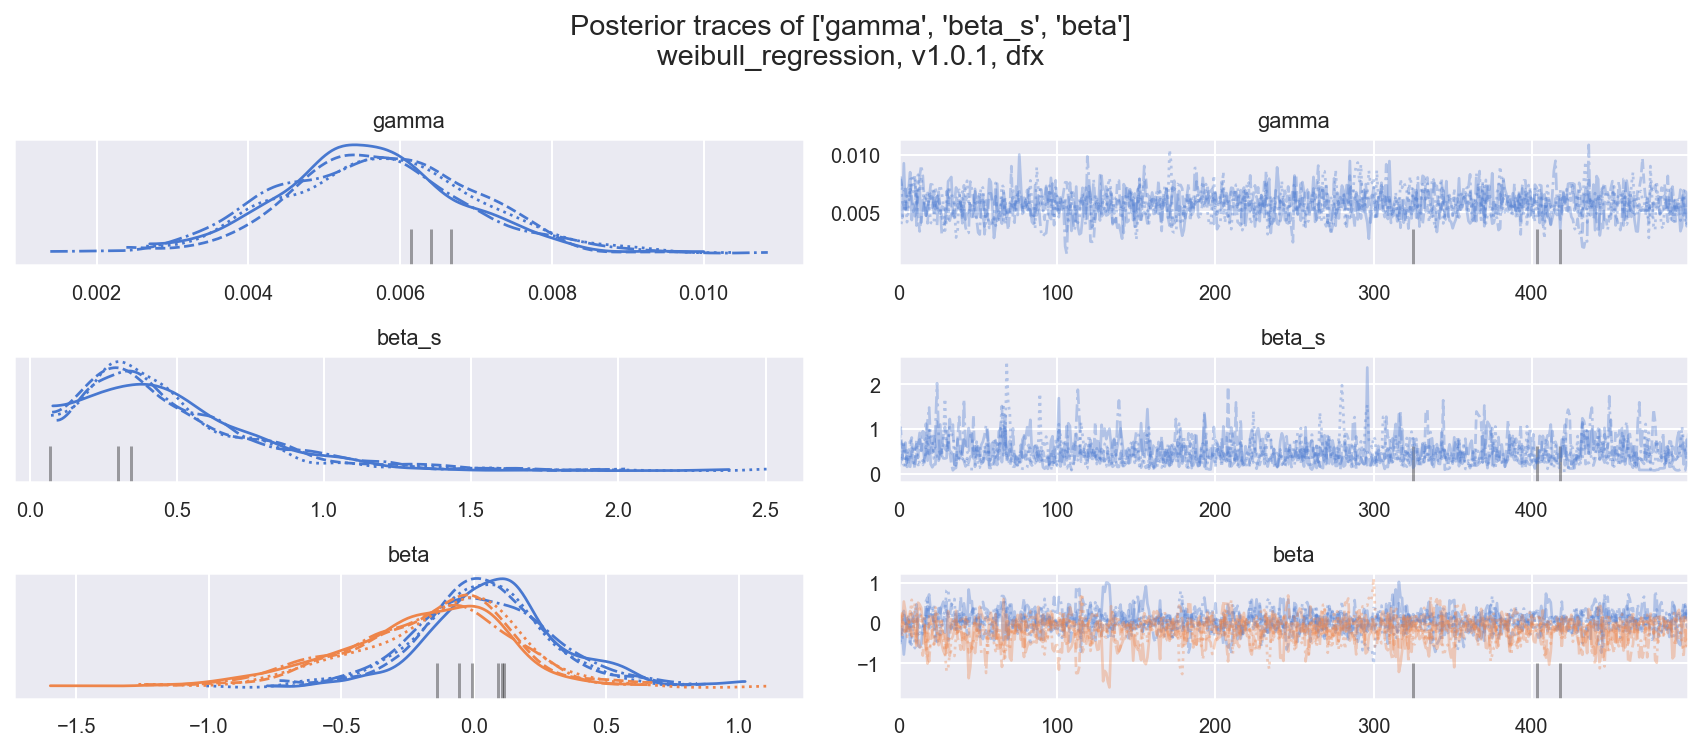

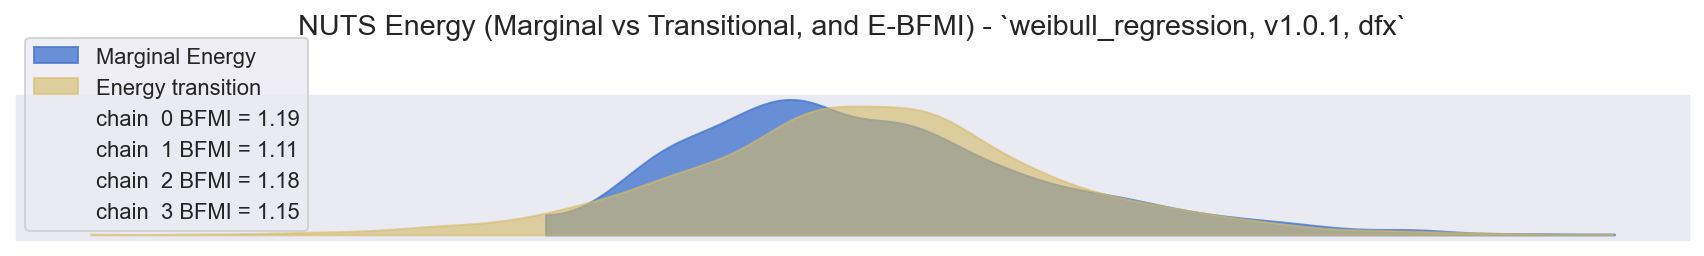

In [17]:
f = mt.plot_trace(mdl=mdl_wr, rvs=mdl_wr.rvs_prior, kind='trace')
f = mt.plot_energy(mdl=mdl_wr)
smry = mt.get_summary(mdl=mdl_wr, rvs=mdl_wr.rvs_prior)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good (although `1.01` > ideal `1.0`)
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample) via ECDF

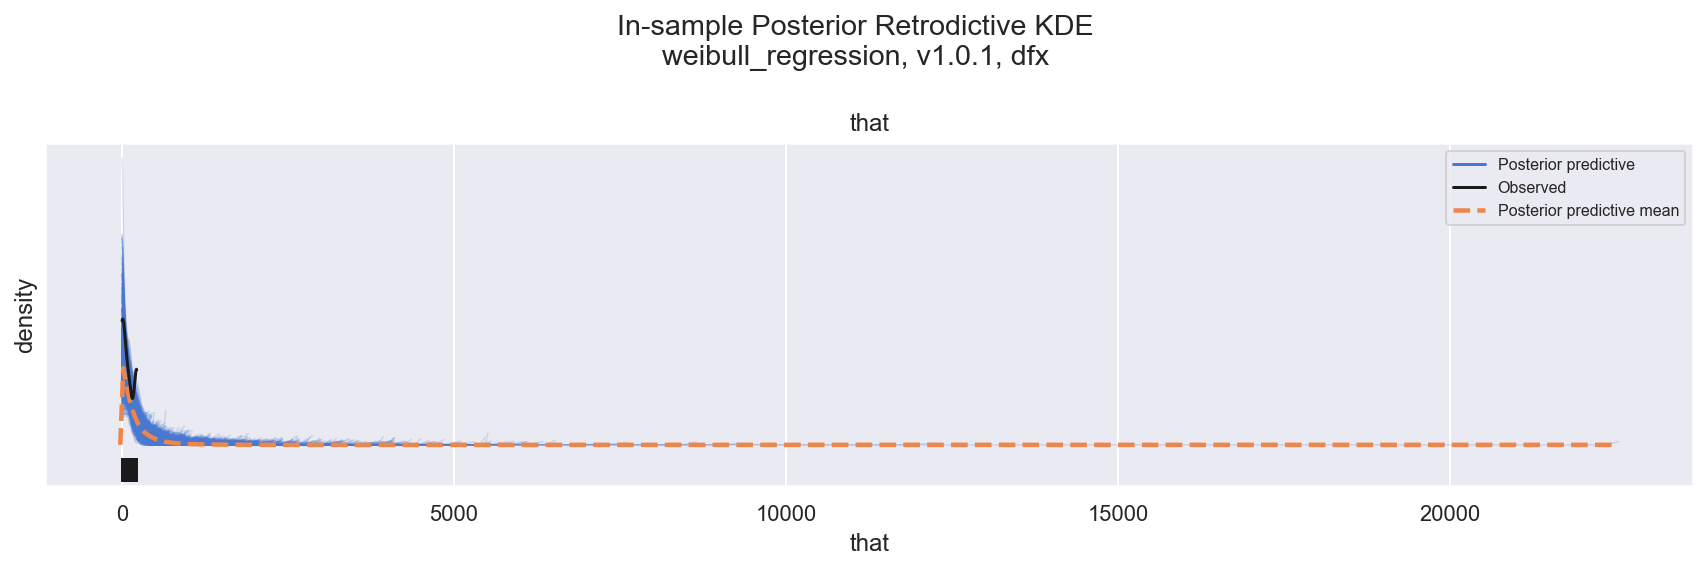

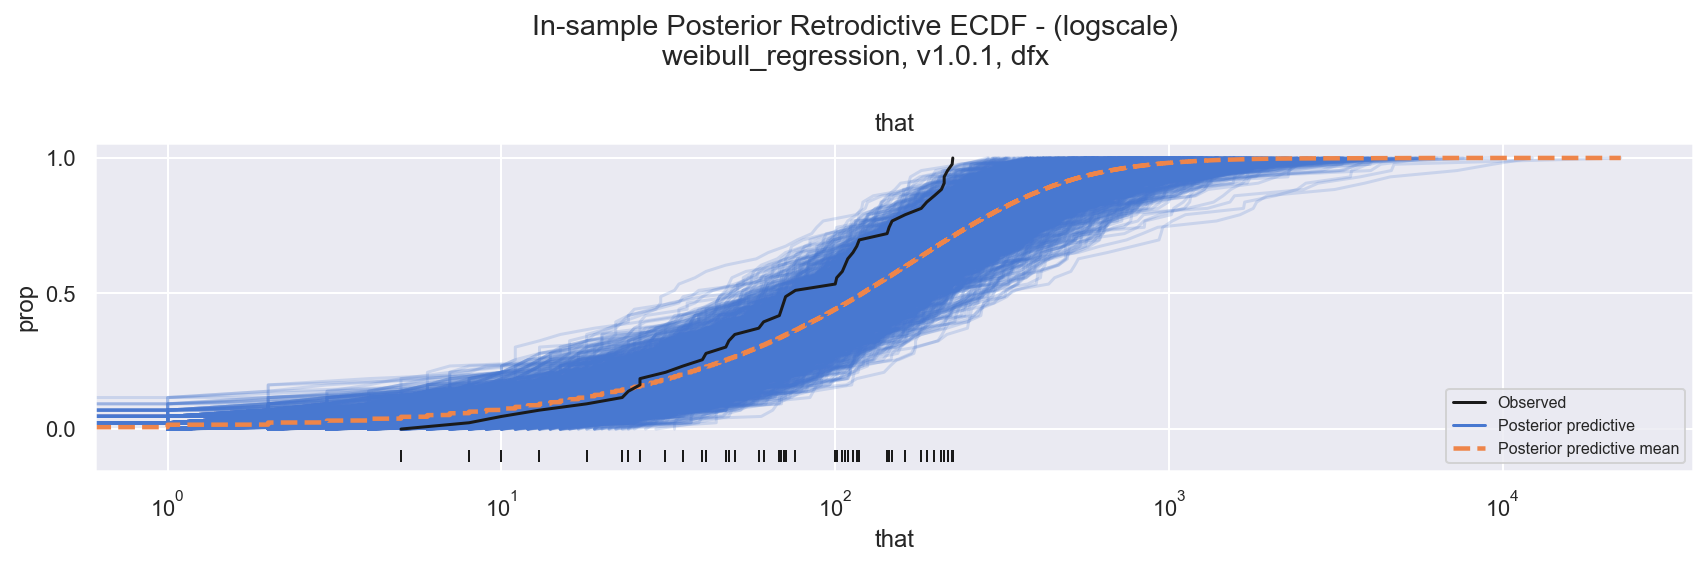

In [18]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_wr, group=GRP, var_names=['that'], ecdf=False, insamp=True)
f = mt.plot_ppc(mdl=mdl_wr, group=GRP, var_names=['that'], insamp=True, logx=True)

**Observe:**

+ This is pretty poor fit (see 2nd plot on logscale): the mean prediction tracks the observed for a while, but departs around $t \approx 100$ and launches off into the right tail, quite overdispersed
+ This suggests the data $\pi(t)$ is not Weibull distributed: the posteriors for $\alpha$ will tell us more

## 2.5 Evaluate via LOO-PIT plots (In-Sample)

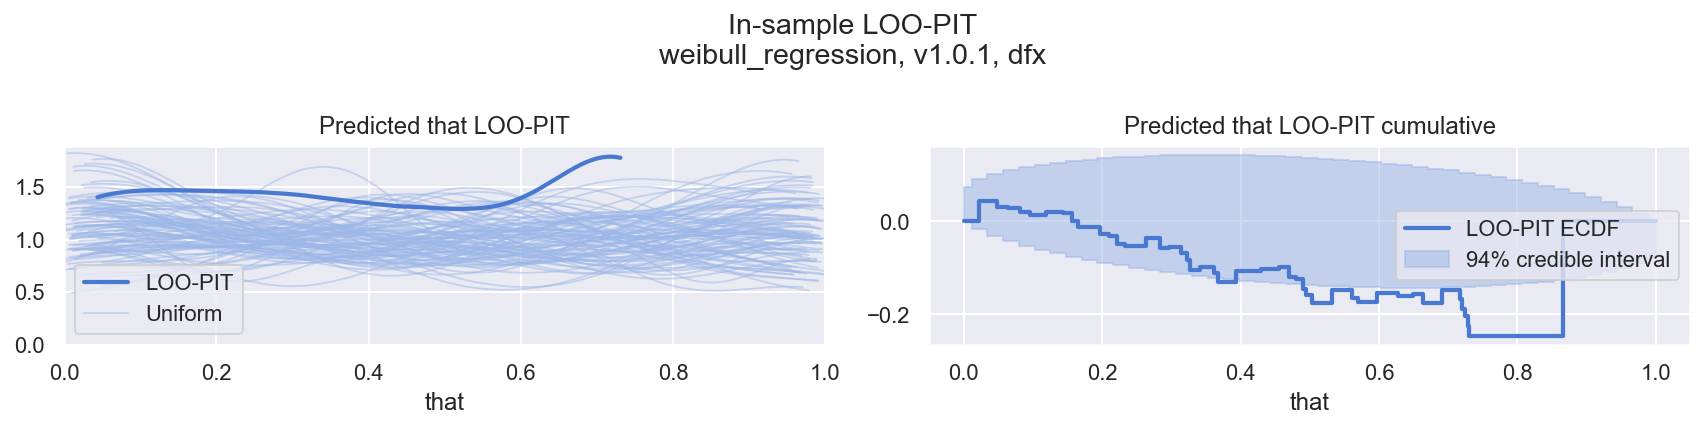

In [19]:
f = mt.plot_loo_pit(mdl_wr, data_pairs={'that': 'that'})

**Observe**

+ Again we see the pretty good: the predictions of yhat are slightly overdispersed compared to the observed data

## 2.6 Compare Log-Likelihood vs other models

### 2.6.1 Reinstantiate earlier models for comparison

In [20]:
mdl_eu = exponential.ExponentialUnivariate(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_eu.build()
mdl_eu_idata = mdlio.read_idata(mdl=mdl_eu)
mdl_eu.update_idata(idata=mdl_eu_idata)

In [21]:
mdl_er = exponential.ExponentialRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_er.build()
mdl_er_idata = mdlio.read_idata(mdl=mdl_er)
mdl_er.update_idata(idata=mdl_er_idata)

### 2.6.2 Compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_er\nexponential_regression_v102_dfx,0,-158.680736,2.083518,0.000000,8.713289e-01,14.643382,0.000000,False,log
mdl_eu\nexponential_univariate_v102_dfx,1,-159.612908,1.179682,0.932172,1.286711e-01,14.892223,1.575394,False,log
mdl_wr\nweibull_regression_v101_dfx,2,-160.238998,2.001912,1.558263,2.220446e-16,15.218603,1.599212,False,log


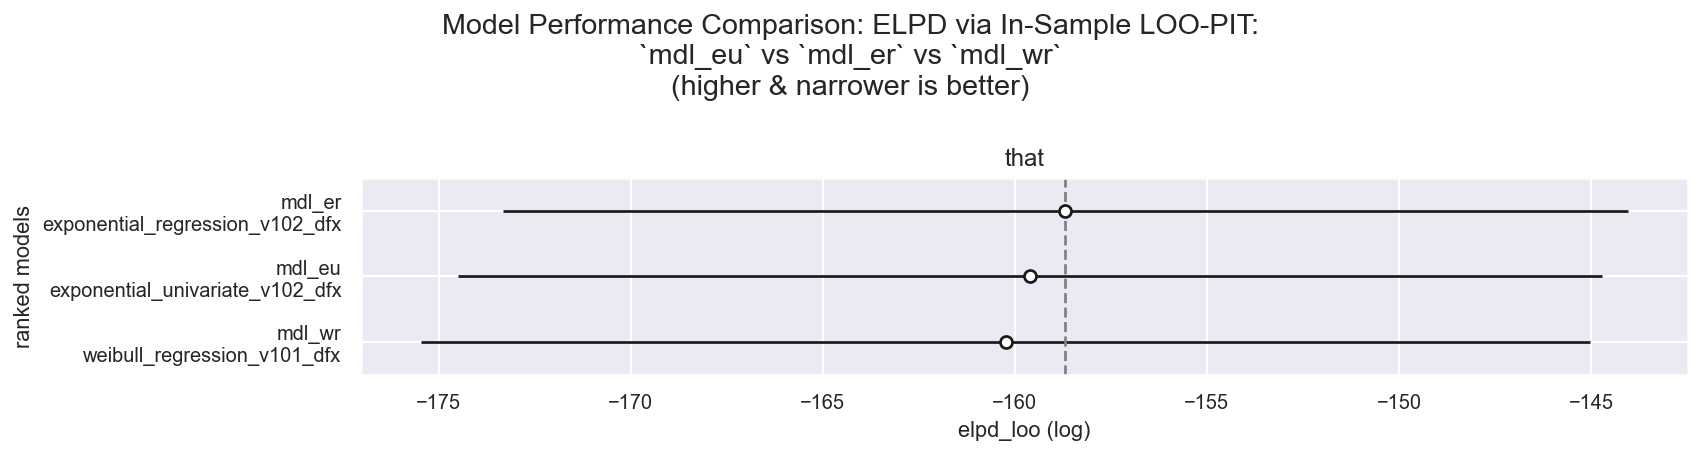

In [22]:
mdl_dict = {'mdl_eu': mdl_eu, 'mdl_er': mdl_er, 'mdl_wr': mdl_wr}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['that'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ The `exponential_regression` model still takes the win, with a slightly better in-sample `elpd_loo` (albeit with a huge overlap)
+ The `weibull_regression` model performs the worst, reinforcing our observation that it might be a poor choice of distribution
  for $\pi(t)$

In [23]:
del mdl_eu, mdl_er

## 2.7 Evaluate Posterior Parameters

#### Evaluate priors and hyperpriors

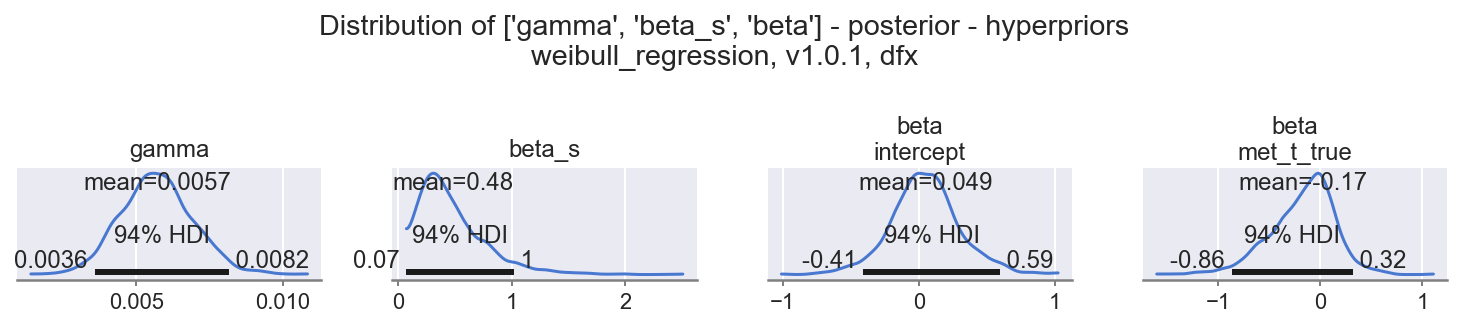

In [24]:
f = mt.facetplot_krushke(mdl=mdl_wr, group=GRP, txtadd='hyperpriors', rvs=mdl_wr.rvs_prior, m=4, rvs_hack=1)
# f = mt.facetplot_krushke(mdl=mdl_wr, group=GRP, txtadd='hyperpriors', rvs=mdl_wr.rvs_prior, hdi_prob = 0.8, m=4, rvs_hack=1)

**Observe:**

+ `gamma`: $\mathbb{E} \sim 0.006$, $\text{HDI}_{94}$ narrower than prior. Located very similar to `exponential_regression` as we would expect
+ `beta_s`: $\mathbb{E} \sim 1.1$, $\text{HDI}_{94}$ quite broad
+ `beta: intercept`: $\mathbb{E} \sim 0.11$, $0 \in \text{HDI}_{94}$. Baseline $\alpha > 1$ later mortality than an exponential model
+ `beta: met_t_true`: $\mathbb{E} \sim -0.3$, $0 \in \text{HDI}_{94}$, but not far off. Pushes $\alpha <1$ earlier mortality

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


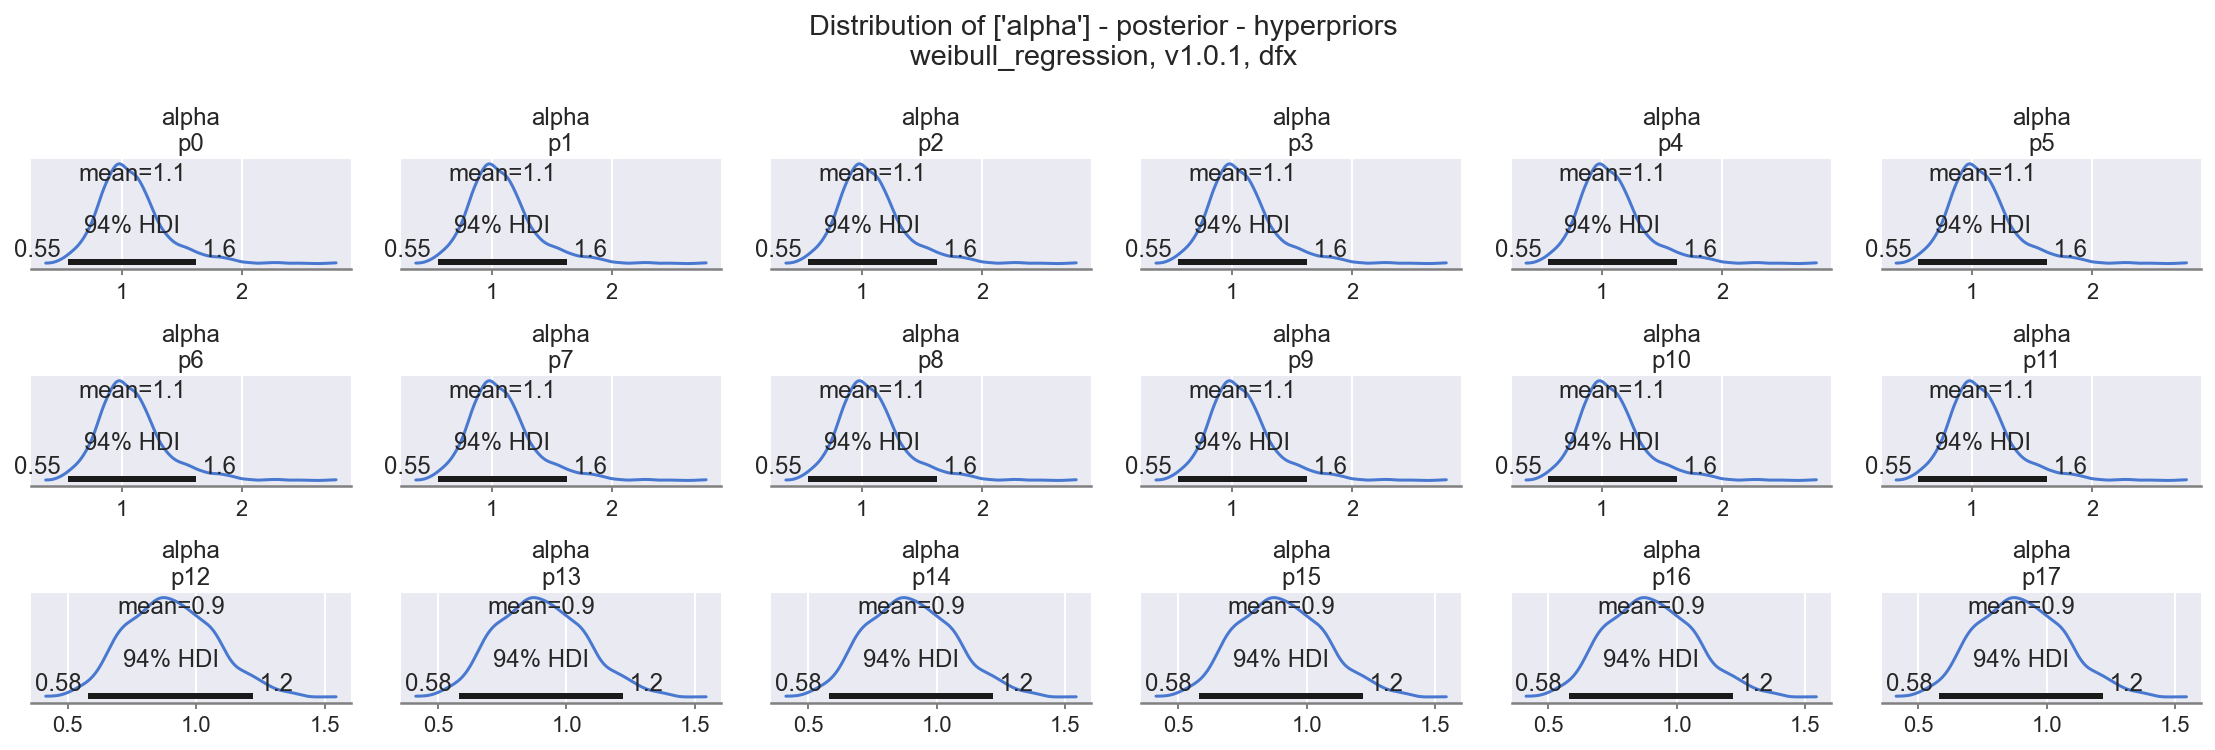

In [25]:
f = mt.facetplot_krushke(mdl=mdl_wr, group=GRP, txtadd='hyperpriors', rvs=mdl_wr.rvs_det, m=6, rvs_hack=2)

**Observe:**

+ Per the dataset and linear model formulation, there's only two groups in here, explained by `met_t_true`. The first 12 are `met_t_true=0`, and the rest (not all are shown for brevity) are `met_t_true=1`
+ As the posteriors on $\beta$ indicated, when `met_t_true=1`, $\alpha < 1$, which means mortality is higher at the start of the observation period

## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is parametric, we can **forecast** Survival $\hat{S}(t)$ and Expected Time-to-Event 
  $\hat{\mathbb{E}}_{t}$ for observations in an **out-of-sample dataset**

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 2.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [26]:
dfs = utils.get_synthetic_df_oos(df, ndur=20)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_wr.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_wr.build()
f_idata = mdl_wr.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_wr.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True)
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,chain,draw,shat,that,oid_sub,t,intercept,met_t_true,pid,met,death,duration
0,z000-0,0,0,1.00,15.0,z000,0,1.0,0.0,z000-0,False,False,0
1,z000-0,0,1,1.00,389.0,z000,0,1.0,0.0,z000-0,False,False,0
2,z000-0,0,2,1.00,743.0,z000,0,1.0,0.0,z000-0,False,False,0
79997,z001-226,3,497,0.21,76.0,z001,226,1.0,1.0,z001-226,True,False,226
79998,z001-226,3,498,0.25,10.0,z001,226,1.0,1.0,z001-226,True,False,226
79999,z001-226,3,499,0.37,54.0,z001,226,1.0,1.0,z001-226,True,False,226


'Shape: (80000, 13), Memsize 8.3 MB'

### 2.8.2 Plot estimated Survival $\hat{S}(t)$

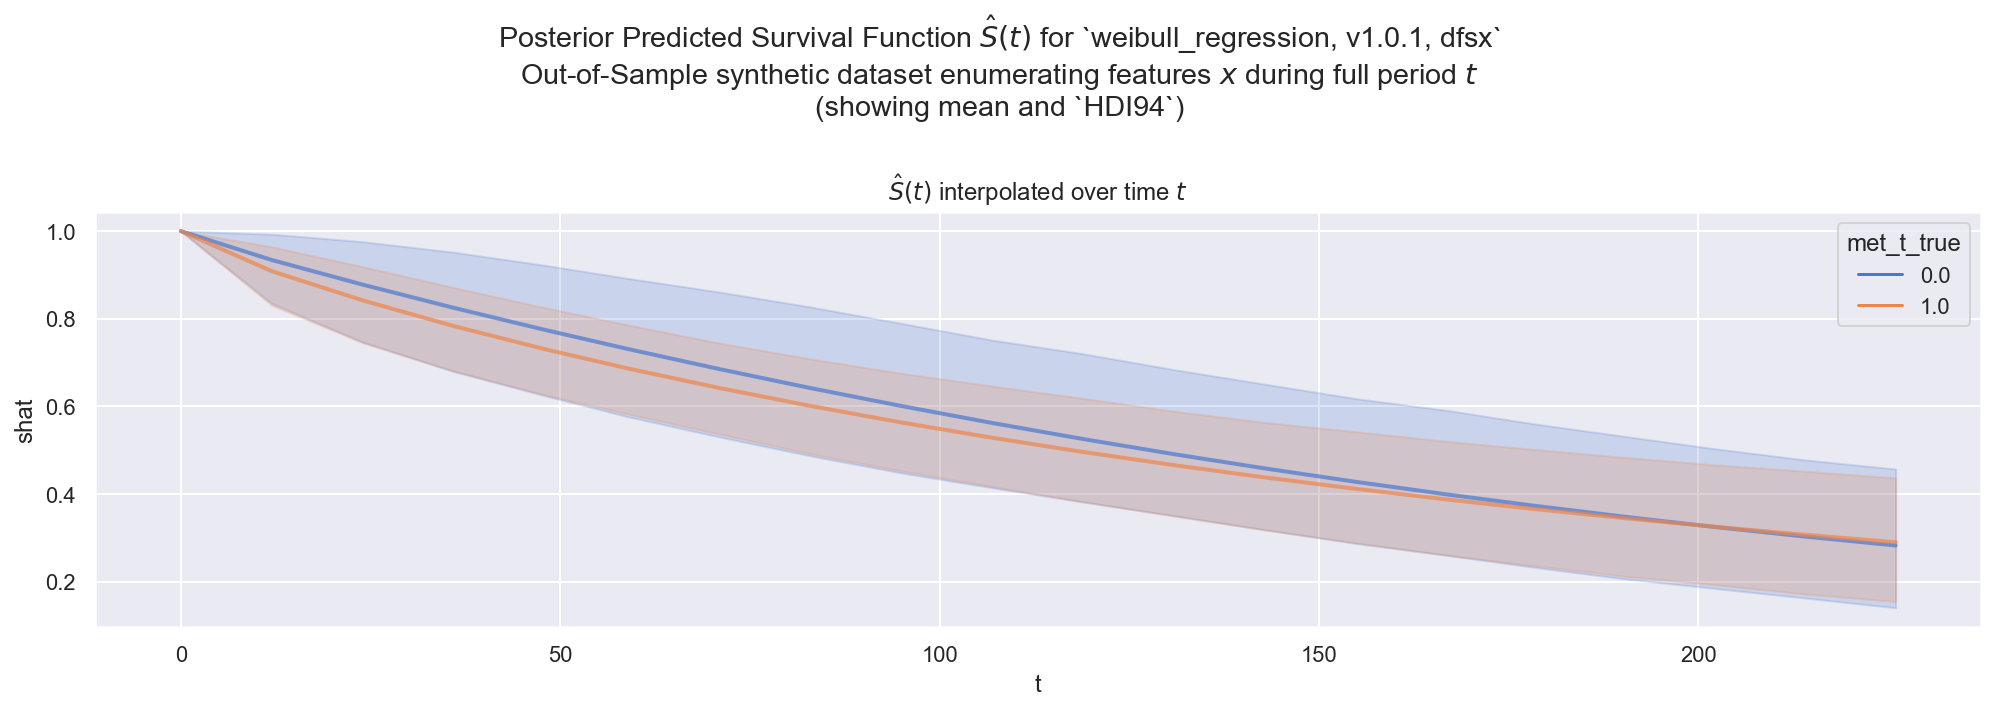

In [27]:
f, axs = plt.subplots(1, 1, figsize=(14, 5), sharex=False)
ax = sns.lineplot(x='t', y='shat',  hue='met_t_true', style='met_t_true', data=dfp, ms=10, dashes=False, 
        alpha=0.7, legend=True, lw=2, ax=axs, estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Function $\hat{{S}}(t)$ for `{mdl_wr.mdl_id}`'
            + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
            + '\n(showing mean and `HDI94`)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'200_{mdl_wr.mdl_id}_forecast_shat')

**Observe:**

+ The predicted survival curves are not very distinct, with substantial overlap, but the `met_t_true=1` clearly has a steeper curve at the start

### 2.8.3 Plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

We will only use Option A: Based on idealised parametric $\hat{\mathbb{E}}_{t} \sim S^{-1}(u) \sim 1/\gamma * (− \log u ) ^{1/\alpha}$

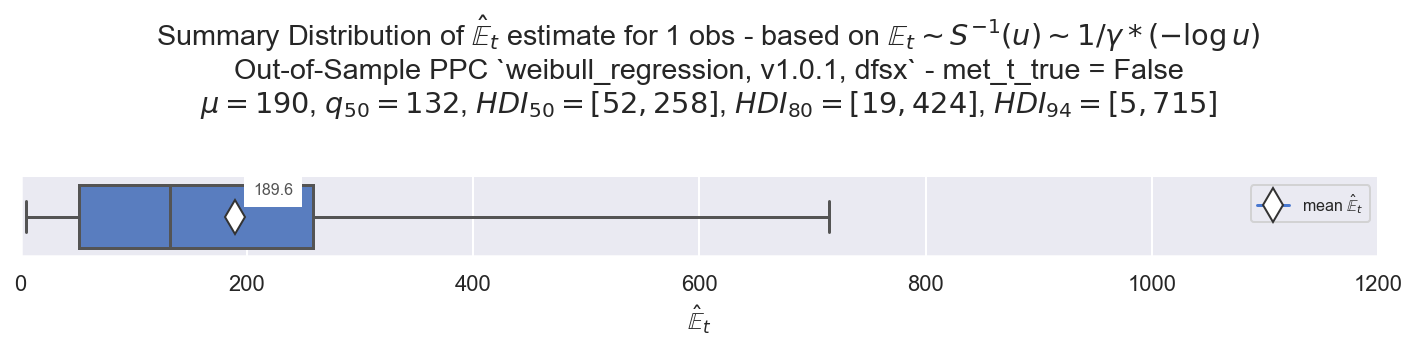

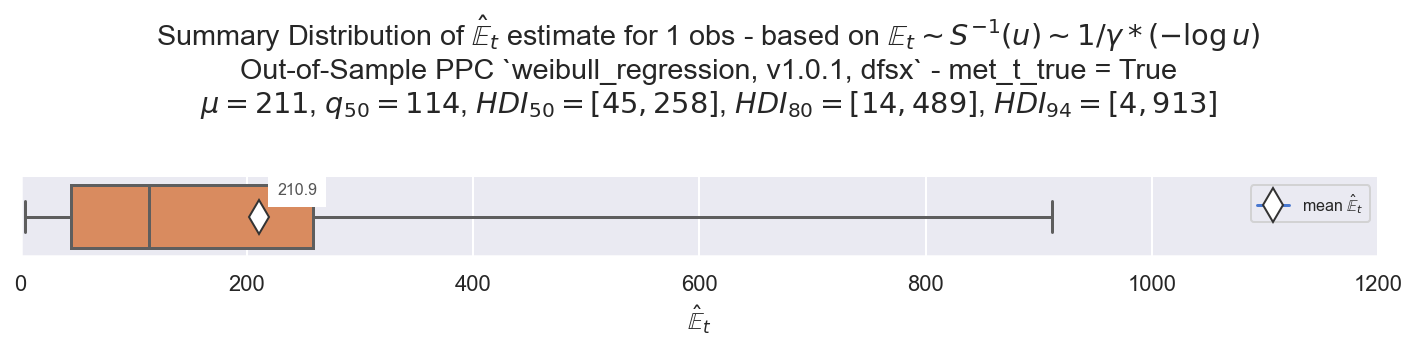

In [28]:
df_et = dfp.loc[dfp['t']==0].groupby(['pid', 'chain', 'draw', 'met_t_true'])['that'].mean().to_frame('$\hat{\mathbb{E}}_{t}$')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 0], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_wr.mdl_id}` - met_t_true = False'), force_xlim=(0, 1200))
fqn = figio.write(f, fn=f'200_{mdl_wr.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 1], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_wr.mdl_id}` - met_t_true = True'), force_xlim=(0, 1200), color='C1')
fqn = figio.write(f, fn=f'200_{mdl_wr.mdl_id}_forecast_et_met_true')

**Observe:**

+ The distributions of forecasted expected survival times $\hat{\mathbb{E}}_{t}$ for our **synthetic out-of-sample dataset** 
  dont look great with this model:
  + For `met = False`: $\hat{\mathbb{E}}_{t} \sim 190 \in [5, 715]_{HDI94}$ days
  + For `met = True`: $\hat{\mathbb{E}}_{t} \sim 211 \in [4, 913]_{HDI94}$ days
+ These empirical predicted distributions have a lot of overlap, more so than the `ExponenentialRegression` model

---

---

# Notes

In [29]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:58:22

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.12.2
oreum_core: 0.9.7
pyprojroot: 0.3.0
scipy     : 1.14.1
matplotlib: 3.9.2
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
pandas    : 2.2.3
numpy     : 1.26.4



---
**Oreum OÜ &copy; 2024**